Utilize os recursos do Pandas, dentre outros recursos disponíveis, para executar as etapas a seguir a partir
do dataset, por você selecionado:

#a

In [1]:
import pandas as pd

df = pd.read_csv('spam.csv')
print(df.columns)


Index(['label', 'text'], dtype='object')


#b

In [2]:

# b)
labels_unicos = df['label'].unique()
print(labels_unicos)

['ham' 'spam']


#c

In [3]:
num_labels = df['label'].apply(lambda x: len(x.split(',')))
quantidade_labels = num_labels.value_counts().sort_index()
print(quantidade_labels)

label
1    10572
Name: count, dtype: int64


#d

In [4]:
from collections import Counter

labels_contagem = Counter()
df['label'].dropna().apply(lambda x: labels_contagem.update(x.split(',')))
print(labels_contagem)

Counter({'ham': 8248, 'spam': 2324})


#e

In [5]:
com_label = df['label'].notna().sum()
sem_label = df['label'].isna().sum()
print(f'Registros com labels: {com_label}, Registros sem labels: {sem_label}')

Registros com labels: 10572, Registros sem labels: 0


4)

In [9]:

# vou usar todos os labels

5)

In [8]:
# todas tem label

6)

In [ ]:
#nao precisa concaquetanar nenhum texto

7)

In [6]:
df.drop_duplicates(subset=['text'], inplace=True)

8)

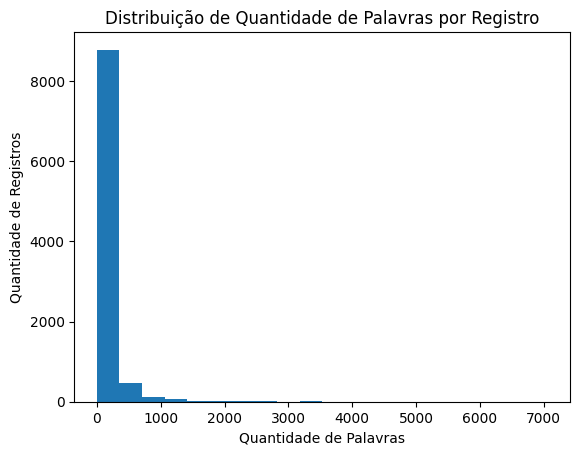

In [7]:
import matplotlib.pyplot as plt

# Contar palavras por registro sem adicionar coluna ao DataFrame
num_palavras = df['text'].apply(lambda x: len(str(x).split()))

# Plotar gráfico
plt.hist(num_palavras, bins=20)
plt.xlabel('Quantidade de Palavras')
plt.ylabel('Quantidade de Registros')
plt.title('Distribuição de Quantidade de Palavras por Registro')
plt.show()

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
from datasets import Dataset, DatasetDict

# Supondo que seu dataframe seja chamado df
# Ajuste aqui se o nome for diferente
all_labels = df["label"].str.split(",").tolist()  # Divide as labels em uma lista
mlb = MultiLabelBinarizer()
mlb.fit(all_labels)

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["label"].str.split(","))  # Transforme as labels em formato binarizado
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

# Supõe-se que o dataframe df tenha as colunas "label" e "text"
np.random.seed(0)

# Dividir os dados
df_train, df_tmp = balanced_split(df, test_size=0.5)  # Divisão do conjunto rotulado
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)  # Divisão do conjunto temporário

# Criar o DatasetDict
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
})

# Se você tiver dados não rotulados e quiser manter essa funcionalidade
# Se não houver dados não rotulados, remova essa parte
df_unsup = df.loc[df["label"].isnull(), ["text", "label"]]  # Apenas exemplo, ajuste conforme necessário
if not df_unsup.empty:
    ds["unsup"] = Dataset.from_pandas(df_unsup.reset_index(drop=True))

# Exibir as informações do Dataset
print(ds)


/home/vitor/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4770
    })
    valid: Dataset({
        features: ['label', 'text'],
        num_rows: 2385
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 2385
    })
})


10)

In [9]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['label'])

train_samples = [8, 16, 32, 64, 128]
train_slices = []
last_k = 0

for k in train_samples:
    X_train, _, y_train, _ = train_test_split(df['text'], labels, train_size=(k - last_k) / len(labels), stratify=labels)
    last_k = k
    train_slices.append((X_train, y_train))

train_slices.append((df['text'], labels))
train_samples.append(len(df))

# Exibir os tamanhos dos slices
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x[0]) for x in train_slices])


Target split sizes:
[8, 16, 32, 64, 128, 9540]
Actual split sizes:
[8, 8, 16, 32, 64, 9540]


11)

Map: 100%|██████████| 4770/4770 [00:00<00:00, 158230.56 examples/s]


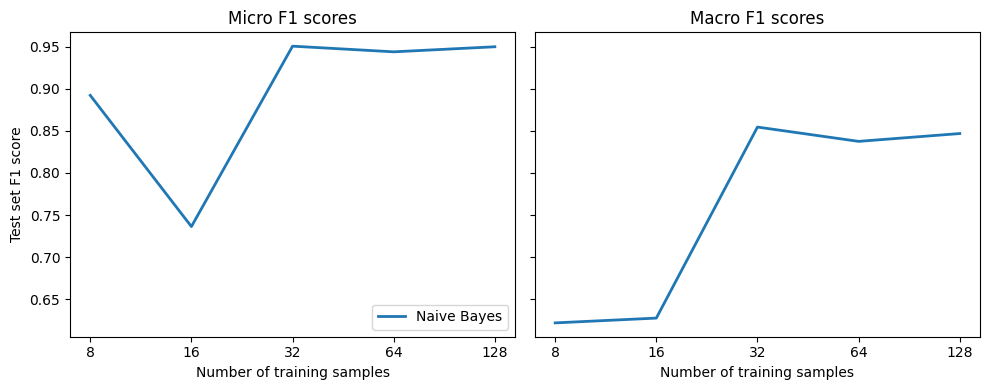

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from skmultilearn.model_selection import iterative_train_test_split

df['text'] = df['text'].fillna('')

mlb = MultiLabelBinarizer()
mlb.fit(df["label"])

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["label"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

np.random.seed(0)
df_train, df_test = balanced_split(df, test_size=0.5)

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True))
})

def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["label"])
    return batch

ds = ds.map(prepare_labels, batched=True)

macro_scores, micro_scores = defaultdict(list), defaultdict(list)
train_samples = [8, 16, 32, 64, 128]  # Tamanhos de amostra desejados
train_slices = [np.random.choice(len(ds["train"]), size=k, replace=False) for k in train_samples]

for train_slice in train_slices:
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)

    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")


In [36]:
from transformers import GPT2Tokenizer, GPT2Model
import faiss
import torch

# Carregar modelo GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("miguelvictor/python-gpt2-large")
model = GPT2Model.from_pretrained("miguelvictor/python-gpt2-large")

# Definir o token de padding
tokenizer.pad_token = tokenizer.eos_token

# Gerar embeddings
texts = df['text'].tolist()
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

# Passar os textos pelo modelo GPT-2 e obter as embeddings
with torch.no_grad():
    embeddings = model(**inputs).last_hidden_state.mean(dim=1).detach().numpy()

# Indexação com FAISS
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

print("Indexação FAISS concluída com sucesso!")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
